In [1]:
import sys 
sys.path.append('..')
from tqdm import tqdm
import datetime
import numpy as np
import torch
from torch.utils.data import DataLoader
#from models import GNN
from dataset import MineDataset
#from pytorch_net.util import Batch
import sys
import os
#os.add_dll_directory("C:\Users\Michael\anaconda3\lib\site-packages\dgl")
import dgl
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
from matplotlib import style
import matplotlib.pyplot as plt
import dgl.nn.pytorch as dglnn
style.use('dark_background')

data_dir = "data"
#set seed
torch.manual_seed(0)
torch.cuda.is_available()

True

In [49]:
# Load dataset
dataset = MineDataset(
    data_dir=data_dir,
    input_steps=80,
    output_steps=1,
)

In [50]:
dataset

MineDataset(1780)

In [51]:
dataset[300].nodes["neuron_basic"].data["feats"].shape

torch.Size([279, 80, 2])

In [52]:
bhg = dgl.batch([g for g in dataset[:20]])
bhg.nodes["neuron_basic"].data["feats"].shape

torch.Size([5580, 80, 2])

In [53]:
import dgl.function as fn

class HeteroRGCNLayer(nn.Module):
    def __init__(self, in_size, out_size, etypes):
        super(HeteroRGCNLayer, self).__init__()
        # W_r for each relation
        self.weight = nn.ModuleDict({
                name : nn.Linear(in_size, out_size) for name in etypes
            })
        
        self.output_weights = nn.Linear(out_size, out_size)

    def forward(self, G, feats):
        # The input is a dictionary of node features for each type
        funcs = {}
        for srctype, etype, dsttype in G.canonical_etypes:
#             neuron_basic chemical neuron_basic
#             neuron_basic electric neuron_basic
            # Compute W_r * h
            Wh = self.weight[etype](feats)
#             import pdb
#             pdb.set_trace()
            # Save it in graph for message passing
            G.nodes[srctype].data['Wh_%s' % etype] = Wh
            # Specify per-relation message passing functions: (message_func, reduce_func).
            # Note that the results are saved to the same destination feature 'h', which
            # hints the type wise reducer for aggregation.
            funcs[etype] = (fn.copy_src('Wh_%s' % etype, 'm'), fn.sum('m', 'h'))
        # Trigger message passing of multiple types.
        # The first argument is the message passing functions for each relation.
        # The second one is the type wise reducer, could be "sum", "max",
        # "min", "mean", "stack"
        G.multi_update_all(funcs, 'sum')
        # return the updated node feature dictionary
        return self.output_weights(G.nodes['neuron_basic'].data['h']) + Wh

In [54]:
class HeteroRGCN(nn.Module):
    def __init__(self, G, in_size, hidden_size, out_size, num_layers=2):
        super(HeteroRGCN, self).__init__()
        # Use trainable node embeddings as featureless inputs.
        embeds = nn.Parameter(torch.Tensor(279, in_size))
        nn.init.xavier_uniform_(embeds)
        self.embed = embeds
        
        node_features = G.nodes['neuron_basic'].data['feats']
        node_features = node_features.reshape(node_features.shape[0],-1)
        
        # create layers
        layers = []
        layers.append(HeteroRGCNLayer(in_size+(node_features.shape[-1]), hidden_size, G.etypes))
#         layers.append(nn.Linear(in_size+(node_features.shape[-1]), hidden_size)) for not considering graph
        
        for _ in range(num_layers):
            layers.append(HeteroRGCNLayer(hidden_size, hidden_size, G.etypes))
#             layers.append(nn.Linear(hidden_size, hidden_size)) for not considering graph

        layers.append(HeteroRGCNLayer(hidden_size, out_size, G.etypes))
#         layers.append(nn.Linear(hidden_size, out_size)) for not considering graph
        self.layers = nn.ModuleList(layers)

    def forward(self, G):
        #import pdb
        #pdb.set_trace()
        node_features = G.nodes['neuron_basic'].data['feats'].to('cuda:0')
        batch_size = node_features.shape[0]//(279)
        node_features = node_features.reshape(node_features.shape[0],-1)
        #print(node_features.shape)
        embed = torch.tile(self.embed, (batch_size,1)).to('cuda:0')
        
        h = torch.cat([embed, node_features], axis = -1)
        
        for i, layer in enumerate(self.layers[:-1]):
            h = layer(G, h)  # layer(h) for not considering graph
            h = F.leaky_relu(h)
#             h = self.norms[i](h)

        h = self.layers[-1](G, h)
        h = h.reshape(h.shape, -1, 2)
        return h

In [55]:
# Create the model. The output has three logits for three classes.
model = HeteroRGCN(dataset[0], 10, 128, 1, num_layers=2).to('cuda:0')
model.train()

opt = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0)  # 5e-4

best_loss = 1e10

losses = []
g = dgl.batch([g for g in dataset[:200]])
g = g.to('cuda:0')
for epoch in range(5000):
#     indices = np.random.choice(128)  if batch size is 128
#     g = dgl.batch([g for g in dataset[indices]])

    voltages = model(g)
    labels = g.nodes['neuron_basic'].data['labels']#[:,0]
    labels = labels.reshape(voltages.shape)
    # The loss is computed only for labeled nodes.
    loss = F.mse_loss(voltages, labels)

    if loss < best_loss:
        best_loss = loss
        #torch.save(model.state_dict(), "checkpoints/")

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    if epoch % 5 == 0:
        losses.append(loss.detach().cpu())

    if epoch % 100 == 0:
        print('Step: %d, Loss %.4f, Best Loss %.4f' % (
            epoch,
            loss.item(),
            best_loss.item(),
        ))

Step: 0, Loss 197698.5469, Best Loss 197698.5469
Step: 100, Loss 26623.5840, Best Loss 26623.5840
Step: 200, Loss 12834.8125, Best Loss 12834.8125
Step: 300, Loss 4440.6777, Best Loss 4440.6777
Step: 400, Loss 2822.2612, Best Loss 2822.2612
Step: 500, Loss 2108.2734, Best Loss 2108.2734
Step: 600, Loss 1633.2634, Best Loss 1633.2634
Step: 700, Loss 1301.1741, Best Loss 1301.1741
Step: 800, Loss 1048.5785, Best Loss 1048.5785
Step: 900, Loss 878.0607, Best Loss 878.0607
Step: 1000, Loss 837.0229, Best Loss 771.9058
Step: 1100, Loss 653.5965, Best Loss 653.5965
Step: 1200, Loss 580.4070, Best Loss 580.4070
Step: 1300, Loss 511.5100, Best Loss 511.5100
Step: 1400, Loss 461.9209, Best Loss 461.9209
Step: 1500, Loss 410.7600, Best Loss 410.7600
Step: 1600, Loss 386.8159, Best Loss 386.8159
Step: 1700, Loss 335.3765, Best Loss 335.3765
Step: 1800, Loss 2513.5571, Best Loss 306.9428
Step: 1900, Loss 277.6496, Best Loss 277.6496
Step: 2000, Loss 250.5681, Best Loss 250.5681
Step: 2100, Loss 23

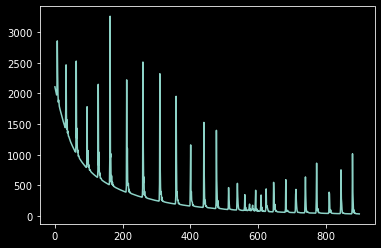

In [56]:
plt.plot(losses[100:])

In [57]:
model.eval()

num_timesteps = 1000
g = dataset[0].to('cuda:0')
voltagelist = []
input_size = g.nodes['neuron_basic'].data['feats'].shape[1]
staticNx1thing = g.nodes['neuron_basic'].data['feats'][:,0,0][:,None]

for i in range(input_size):
    voltagelist.append(g.nodes['neuron_basic'].data['feats'][:,i,1])

for i in range(num_timesteps): #number of timesteps to predict
    voltages = model(g)


    newfeature = torch.cat([staticNx1thing,voltages],1) #-> torch.Size([1054341, 2])
    newfeature = newfeature[:,None] #-> torch.Size([1054341, 1, 2])     
    modifiedvoltage = torch.cat([g.nodes['neuron_basic'].data['feats'][:,1:],newfeature],1)
    g.nodes['neuron_basic'].data['feats'] = modifiedvoltage
    
    voltagelist.append(voltages[:,0])

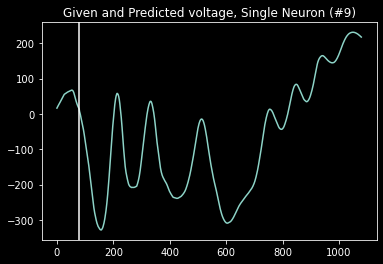

In [60]:
torch.stack(voltagelist)
plt.plot(torch.stack(voltagelist)[:,9].detach().cpu().numpy());
plt.axvline(x=input_size)
plt.title('Given and Predicted voltage, Single Neuron (#9)')
plt.show();

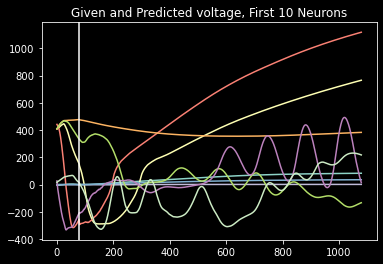

In [61]:
torch.stack(voltagelist)
for i in range(1,10):
    plt.plot(torch.stack(voltagelist)[:,i].detach().cpu().numpy());
plt.axvline(x=input_size)
plt.title('Given and Predicted voltage, First 10 Neurons')
plt.show();